In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import requests as re
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import plotly.express as px
from sklearn.cluster import KMeans
import tqdm
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

## Getting data through API

In [2]:
# Original data retrieved here.
api = "https://crashviewer.nhtsa.dot.gov/CrashAPI/FARSData/GetFARSData?dataset=Vehicle&FromYear=2020&&ToYear=2021&State=*&format=json"
res = re.get(api)

data = res.json()["Results"][0]

In [4]:
# Format as pandas DataFrame and save it to data folder
usefulColumns = ["DEATHS", "DR_DRINK", "DR_HGT", "DR_WGT", "HIT_RUNNAME", 
                 "TRAV_SP", "HOUR", "MOD_YEAR", "MODELNAME", "VSPD_LIM", "VPICBODYCLASSNAME",
                "NUMOCCS", "MAKENAME", "MINUTE"]

df = pd.DataFrame({k: [d[k] for d in data] for k in usefulColumns})

NameError: name 'data' is not defined

In [5]:
df = pd.read_csv("../data/data-clean/super-clean-vehicle-2020-2021.csv", index_col = 0)
df.head()

,DEATHS,DR_DRINK,DR_HGT,DR_WGT,HIT_RUNNAME,TRAV_SP,HOUR,MOD_YEAR,MODELNAME,VSPD_LIM,VPICBODYCLASSNAME,NUMOCCS,MAKENAME,MINUTE,TIME,APRX_WGT,MOD_YEAR_5YR_CHUNK,RELATIVE_SPEED,BMI,DEATHOCCURRED
0,3,1,67,145,NaN,80,2,1997,ES-250/300/300h/330/ 350,45,Sedan/Saloon,4,Lexus,58,2.966667,3607.664797,1995,35,22.707730,1
1,1,0,67,215,NaN,70,14,1995,Camry,65,Sedan/Saloon,1,Toyota,55,14.916667,3306.360995,1995,5,33.670082,1
2,0,0,68,228,NaN,10,14,2016,Medium/Heavy - CBE,55,Truck-Tractor,1,Peterbilt,55,14.916667,18527.497000,2015,-45,34.663495,0
3,1,0,73,133,NaN,80,15,2007,"Azera (For 2018 on, code as vehicle model 398)",35,Sedan/Saloon,5,Hyundai,20,15.333333,3451.129813,2005,45,17.545318,1
4,1,0,64,115,NaN,70,0,2013,Suburban/Yukon XL (2004 on; see 431 for 1950- ...,45,Sport Utility Vehicle (SUV)/Multi-Purpose Vehi...,1,GMC,45,0.750000,4795.468142,2015,25,19.737549,1


## Cleaning Data

### Firstly, convert all relevant data types to float

In [6]:
# Change Dtype to int for relevant columns
str_cols = ["MAKENAME", "VPICBODYCLASSNAME", "MODELNAME", "HIT_RUNNAME"]
type_change = {col: int for col in df.columns if col not in str_cols}
df = df.astype(type_change)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DEATHS              23171 non-null  int32  
 1   DR_DRINK            23171 non-null  int32  
 2   DR_HGT              23171 non-null  int32  
 3   DR_WGT              23171 non-null  int32  
 4   HIT_RUNNAME         0 non-null      float64
 5   TRAV_SP             23171 non-null  int32  
 6   HOUR                23171 non-null  int32  
 7   MOD_YEAR            23171 non-null  int32  
 8   MODELNAME           23171 non-null  object 
 9   VSPD_LIM            23171 non-null  int32  
 10  VPICBODYCLASSNAME   23171 non-null  object 
 11  NUMOCCS             23171 non-null  int32  
 12  MAKENAME            23171 non-null  object 
 13  MINUTE              23171 non-null  int32  
 14  TIME                23171 non-null  int32  
 15  APRX_WGT            23171 non-null  int32  
 16  MOD_

### Only use the most common vehicles types

In [7]:
# Define the body categories to keep as they are
keep_categories = ['Sedan/Saloon', 'Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)', 
                   'Pickup', 'Hatchback/Liftback/Notchback', 'Coupe', 'Minivan', 'Truck-Tractor']

# Function to recategorize the data
def recategorize(row):
    if row in keep_categories:
        # Return entry as is if it is in the keep_categories list
        return row
    elif 'Motorcycle' in row:
        # Combine all motorcycle entries
        return 'Motorcycle'
    else:
        # Else return "Other", to be filtered out
        return 'Other'

# Apply the recategorize function to the body class name
df['VPICBODYCLASSNAME'] = df['VPICBODYCLASSNAME'].apply(recategorize)

# Finally, filter out all body types that are "Other"
df = df[df.VPICBODYCLASSNAME != "Other"]

# Now let's see the new value counts
print(df['VPICBODYCLASSNAME'].value_counts())

Sedan/Saloon                                               7216
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)    5659
Pickup                                                     4474
Motorcycle                                                 2190
Truck-Tractor                                              1407
Coupe                                                       833
Hatchback/Liftback/Notchback                                816
Minivan                                                     576
Name: VPICBODYCLASSNAME, dtype: int64


### Combine `HOUR` and `MINUTE`

In [8]:
df["TIME"] = df["HOUR"] + df["MINUTE"]/60

### Handle outliers and unknown information

In [9]:
# Remove speeds beyond 151 MPH
df = df[df['TRAV_SP'] <= 151]

# Include driver weights between 40-700 lbs and 
# driver heights between 40 and 107 inches
df = df[(df["DR_WGT"] >= 40) & (df["DR_WGT"] <= 700)]
df = df[(df["DR_HGT"] >= 40) & (df["DR_HGT"] <= 107)]

# Only include hours between 0 and 23
df = df[df["HOUR"] < 24]

# Remove unknown or undocumented model years
df = df[df['MOD_YEAR'] < 2021]

# Remove unknown make names (companies) and those with less than 100 occurences
value_counts = df['MAKENAME'].value_counts()
valid_makenames = value_counts[value_counts >= 10].index
exclusions = {"Unknown Make", "Other Make", "Other Import", "Other Domestic Manufacturers"}
valid_makenames = set(valid_makenames) - exclusions
df = df[df['MAKENAME'].isin(valid_makenames)]

### Map vehicle body type to average weights

In [10]:
def map_vehicle_to_weight(vehicle_type):
    # Define weight distributions (mean, std) for each vehicle type
    weight_distributions = {
        'Sedan/Saloon': (3300, 300),
        'Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)': (4500, 500),
        'Pickup': (5500, 600),
        'Motorcycle': (500, 100),
        'Coupe': (3300, 300),
        'Hatchback/Liftback/Notchback': (3300, 300),
        'Minivan': (4500, 400),
        'Truck-Tractor': (20000, 2000)
    }
    
    # Retrieve the distribution for the specified vehicle type
    distribution = weight_distributions.get(vehicle_type)
    
    if distribution:
        # Generate a random weight from the normal distribution
        mean, std = distribution
        return max(0, np.random.normal(mean, std))  # Ensure non-negative weights
    else:
        return "Unknown"

df["APRX_WGT"] = df["VPICBODYCLASSNAME"].map(map_vehicle_to_weight)

### Map boolean variables to 0 or 1

In [11]:
df["HIT_RUNNAME"] = df["HIT_RUNNAME"].map({"No":0, "Yes":1})

### Chunk model years into 5 year groupings.

In [12]:
df['MOD_YEAR_5YR_CHUNK'] = ((df['MOD_YEAR'].astype(int) + 2) // 5) * 5

### Remove unknown number of occupants

In [13]:
df = df[df["NUMOCCS"] < 99]

### Make a relative speed column (TRAV_SP - VSPD_LIM)

In [14]:
df['RELATIVE_SPEED'] = df["TRAV_SP"] - df["VSPD_LIM"] # positive values indicate speeding

### Make BMI

In [15]:
df["BMI"] = df['DR_WGT'] / df['DR_HGT']**2 * 703
# df.BMI = df.BMI.apply(lambda num: math.floor(num * 2) / 2)

### Create a target column called `DEATHOCCURRED` that is a boolean for whether or not anyone died.

In [16]:
df['DEATHOCCURRED'] = np.where(df['DEATHS'].astype(int) > 0, 1, 0)

### Data before one hot encoding of two categorical variables: `MAKENAME` and `VPICBODYCLASSNAME`

In [17]:
df = df.reset_index(drop = True)
df.to_csv("../data/data-clean/super-clean-vehicle-2020-2021.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23171 entries, 0 to 23170
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DEATHS              23171 non-null  int32  
 1   DR_DRINK            23171 non-null  int32  
 2   DR_HGT              23171 non-null  int32  
 3   DR_WGT              23171 non-null  int32  
 4   HIT_RUNNAME         0 non-null      float64
 5   TRAV_SP             23171 non-null  int32  
 6   HOUR                23171 non-null  int32  
 7   MOD_YEAR            23171 non-null  int32  
 8   MODELNAME           23171 non-null  object 
 9   VSPD_LIM            23171 non-null  int32  
 10  VPICBODYCLASSNAME   23171 non-null  object 
 11  NUMOCCS             23171 non-null  int32  
 12  MAKENAME            23171 non-null  object 
 13  MINUTE              23171 non-null  int32  
 14  TIME                23171 non-null  float64
 15  APRX_WGT            23171 non-null  float64
 16  MOD_

### One-hot encode categorical variables

In [18]:
categorical_columns = ['MAKENAME', 'VPICBODYCLASSNAME']  
df_onehot = pd.get_dummies(df, columns=categorical_columns)

## Models

### Implement random forest

In [19]:
drunk = df[df.DR_DRINK == 1]

In [20]:
# Split data into features and target
X = drunk.drop(["DEATHS", "DEATHOCCURRED", "MODELNAME", "HIT_RUNNAME",
             "MAKENAME", "VPICBODYCLASSNAME", 
               "MOD_YEAR_5YR_CHUNK"], axis=1)
y = drunk['DEATHOCCURRED']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Initialize and fit the Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Get feature importances
feature_importances = rf.feature_importances_
feature_names = X.columns

# Create a DataFrame of features and their importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Output MSE and top 10 important features
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(feature_importance_df.head(25))

Accuracy: 81.56%
           Feature  Importance
10        APRX_WGT    0.148089
9             TIME    0.108760
12             BMI    0.104465
3          TRAV_SP    0.093503
11  RELATIVE_SPEED    0.091849
5         MOD_YEAR    0.087282
8           MINUTE    0.085345
2           DR_WGT    0.078579
1           DR_HGT    0.071059
6         VSPD_LIM    0.056616
4             HOUR    0.053239
7          NUMOCCS    0.021214
0         DR_DRINK    0.000000


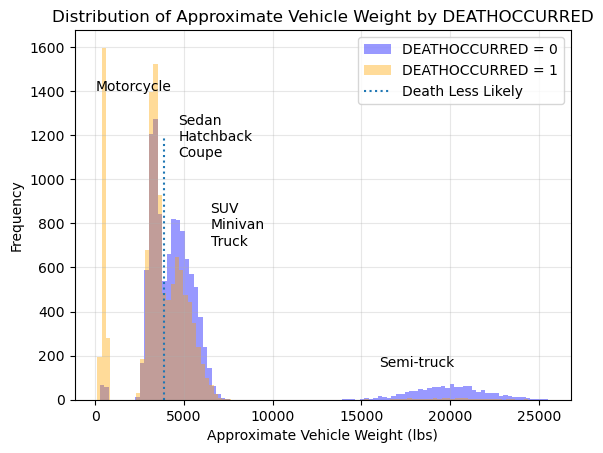

In [21]:
grouped = df.groupby("DEATHOCCURRED")

colors = {0: 'blue', 1: 'orange'}

# Create the histogram
fig, ax = plt.subplots()
for key, group in grouped:
    group['APRX_WGT'].hist(ax=ax, alpha=0.4, bins=100, color=colors[key], label=f'DEATHOCCURRED = {key}')

ax.annotate('Motorcycle', xy=(420, 1400), xytext=(0, 1400))
ax.annotate('Sedan\nHatchback\nCoupe', xy=(4700, 1500), xytext=(4700, 1100))
ax.annotate('SUV\nMinivan\nTruck', xy=(6000, 800), xytext=(6500, 700))
ax.annotate('Semi-truck', xy=(20000, 200), xytext=(16000, 150))
    
ax.set_title('Distribution of Approximate Vehicle Weight by DEATHOCCURRED')
ax.set_xlabel('Approximate Vehicle Weight (lbs)')
ax.set_ylabel('Frequency')
ax.grid(alpha = 0.3)
ax.vlines(3900, 0, 1200, linestyle = "dotted", label = "Death Less Likely")
ax.legend()

plt.savefig("../plots/by_weight_deathsoccurred.png")

# Show the plot
plt.show()

### PCA analysis

In [22]:
features = df.drop(["DEATHS", "DEATHOCCURRED", "MODELNAME",  "HIT_RUNNAME",
                    "MAKENAME", "VPICBODYCLASSNAME"], axis=1)
target = df['DEATHOCCURRED']

X = features.values
X_norm = scale(X.astype(float))

# PCA Transformation
pca = PCA(n_components  = 3)
pca_result = pca.fit_transform(X_norm)

resDF = pd.DataFrame(pca_result, columns = ["PC1", "PC2", "PC3"])

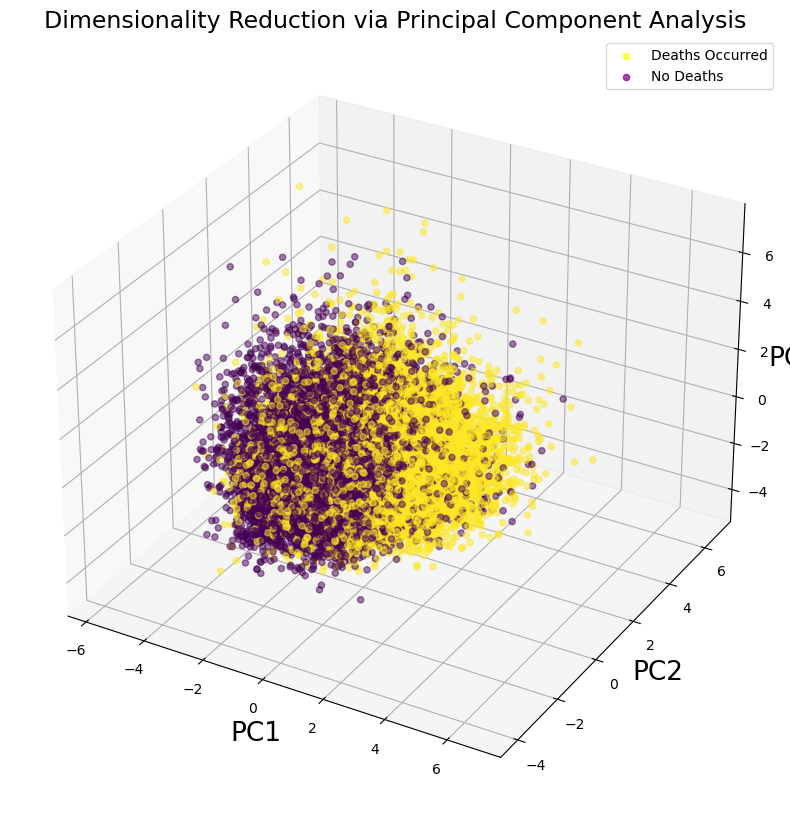

In [23]:
# Plotting the PCA results
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_result[:, 0], 
            pca_result[:, 1],
            pca_result[:, 2],
            c=target, 
            cmap='viridis', alpha=0.5)
plt.title('PCA')
# Create a scatter plot for each category to establish the colors
for i, color in enumerate(['yellow', 'purple']):
    ax.scatter([], [], c=color, label=['Deaths Occurred', 'No Deaths'][i], alpha=0.7)

# Add the legend to the plot
ax.legend()
ax.set_xlabel("PC1", fontsize = 19)
ax.set_ylabel("PC2", fontsize = 19)
ax.set_zlabel("PC3", fontsize = 19)
ax.set_title("Dimensionality Reduction via Principal Component Analysis", fontsize = 17)
plt.savefig("../plots/PCA_3D.png")
plt.show()

In [21]:
fig = px.scatter_3d(resDF, x='PC1', y='PC2', z='PC3',
              color=df.DEATHOCCURRED)
fig.write_html('../html/PCA.html', auto_open=True)

30
acc: 0.6662638643131501


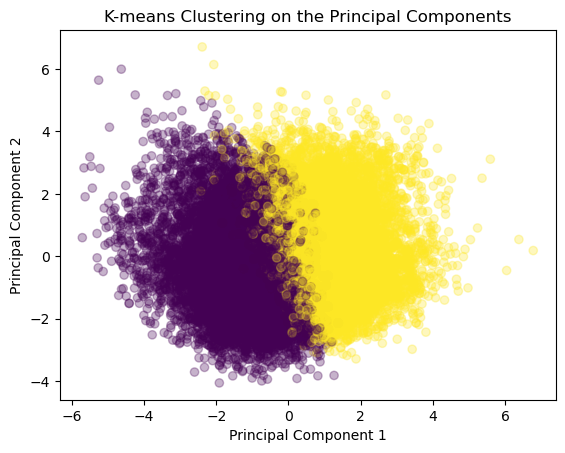

In [24]:
for num in range(30, 31):
    print(num)
    kmeans = KMeans(n_clusters=2, random_state = num, n_init = "auto")  # Specify the number of clusters
    clusters = kmeans.fit_predict(pca_result)
    
    df_clusters = df.copy()
    df_clusters["CLUSTERS"] = clusters
    acc = (df_clusters.CLUSTERS == df_clusters.DEATHOCCURRED).sum()/len(df_clusters.CLUSTERS)
    print(f"acc: {acc}")

    # Plotting the results
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=clusters, alpha = 0.3)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('K-means Clustering on the Principal Components')
    plt.savefig("../plots/k_means.png")
    plt.show()

In [58]:
resDF

,PC1,PC2,PC3
0,3.624221,1.847849,-0.908130
1,1.369045,0.758967,2.103076
2,-3.600666,-0.052682,0.701724
3,2.614274,-0.594674,-0.771297
4,0.897800,1.262093,-3.471305
...,...,...,...
23166,1.926547,1.382182,-0.177319
23167,0.786856,-0.405542,0.347777
23168,0.565782,-0.979890,0.285122
23169,-1.129433,2.045941,-0.591080


#### Clustered it into two clusters because the PCA analysis shows one cluster with a heterogenous mix of fatality/no fatality where the two smaller clusters are 0 fatalities.

In [55]:
### apply SVM to the data above


clf = svm.SVC( C = 1250) # Linear Kernel
X_train, X_test, y_train, y_test = train_test_split(pca_result, df.DEATHOCCURRED, test_size=0.3)
#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# accuracy
acc = np.sum(y_test == y_pred)/len(y_test)
acc

0.68397583429229

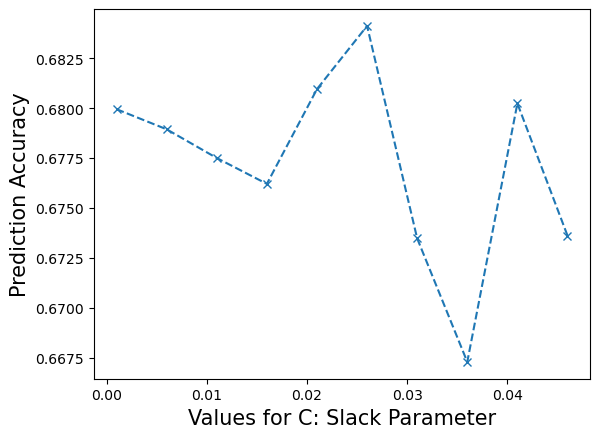

In [43]:
fig, ax = plt.subplots()

ax.plot(Cvals, accs, 'x--')
ax.set_xlabel("Values for C: Slack Parameter", fontsize = 15)
ax.set_ylabel("Prediction Accuracy", fontsize = 15)
plt.savefig("../plots/slack_param_analysis.png")
plt.show()

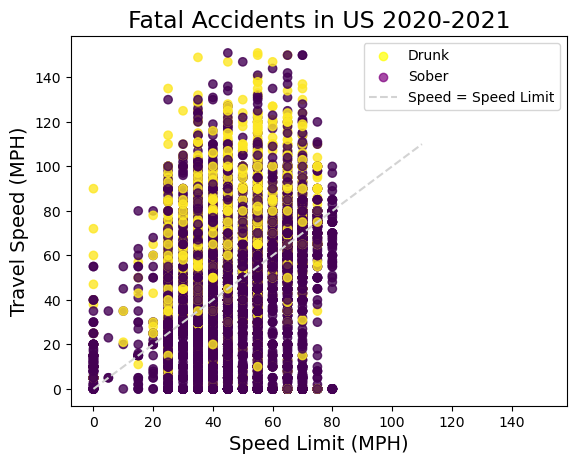

In [812]:
fig, ax = plt.subplots()

mask = (df.TRAV_SP < 200) & (df.VSPD_LIM < 90)
ax.scatter(df.VSPD_LIM[mask], 
           df.TRAV_SP[mask], 
           c = df.DR_DRINK[mask], alpha = 0.8)
ax.set_xlim(ax.get_ylim())

x = np.linspace(0, 110, 1000)
for i, color in enumerate(['yellow', 'purple']):
    ax.scatter([], [], c=color, label=['Drunk', 'Sober'][i], alpha=0.7)
    
ax.plot(x, x, '--', color = "lightgrey", label = "Speed = Speed Limit")
ax.legend()

ax.set_title("Fatal Accidents in US 2020-2021", fontsize = 17)
ax.set_xlabel("Speed Limit (MPH)", fontsize = 14)
ax.set_ylabel("Travel Speed (MPH)", fontsize = 14)
plt.savefig("../plots/travelSpeed_vs_speedLimit.png")
plt.show()

In [813]:
df.VPICBODYCLASSNAME.value_counts()

Sedan/Saloon                                               7216
Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)    5659
Pickup                                                     4474
Motorcycle                                                 2190
Truck-Tractor                                              1407
Coupe                                                       833
Hatchback/Liftback/Notchback                                816
Minivan                                                     576
Name: VPICBODYCLASSNAME, dtype: int64

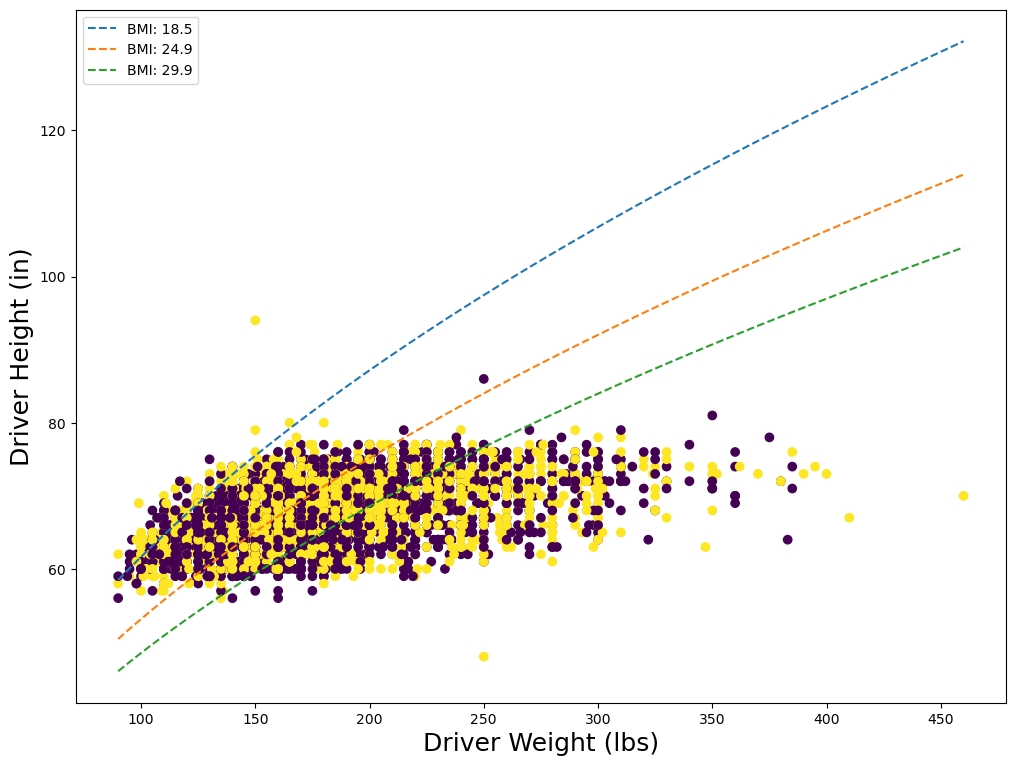

In [814]:
fig, ax = plt.subplots(figsize = (12, 9))

df_sedan = df[df["VPICBODYCLASSNAME"] == "Sport Utility Vehicle (SUV)/Multi-Purpose Vehicle (MPV)"]

ax.scatter(df_sedan.DR_WGT.astype(float), 
           df_sedan.DR_HGT.astype(float), 
           c = df_sedan.DEATHOCCURRED)

def height_by_BMI(weight, BMI):
    
    h = np.sqrt(weight/BMI * 703)
    
    return h 


bmis = [18.5, 24.9, 29.9]

for bmi in bmis:
    w = np.linspace(np.min(df_sedan.DR_WGT.astype(float)), np.max(df_sedan.DR_WGT.astype(float)), 100)
    ax.plot(w, height_by_BMI(w, bmi), '--', alpha = 1, label = f"BMI: {bmi}")

ax.set_xlabel("Driver Weight (lbs)", fontsize = 18)
ax.set_ylabel("Driver Height (in)", fontsize = 18)
ax.legend()
plt.show()
